In [29]:
from keras.layers import Input, Lambda, Dense
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os.path
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

In [30]:
df = pd.read_csv('../input/happy-whale-and-dolphin/train.csv')
df.head()

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392


In [31]:
df.shape

(51033, 3)

In [32]:
df.species.nunique()

30

In [33]:
df.species.value_counts().sort_index()

beluga                       7443
blue_whale                   4830
bottlenose_dolphin           9664
bottlenose_dolpin            1117
brydes_whale                  154
commersons_dolphin             90
common_dolphin                347
cuviers_beaked_whale          341
dusky_dolphin                3139
false_killer_whale           3326
fin_whale                    1324
frasiers_dolphin               14
globis                        116
gray_whale                   1123
humpback_whale               7392
kiler_whale                   962
killer_whale                 1493
long_finned_pilot_whale       238
melon_headed_whale           1689
minke_whale                  1608
pantropic_spotted_dolphin     145
pilot_whale                   262
pygmy_killer_whale             76
rough_toothed_dolphin          60
sei_whale                     428
short_finned_pilot_whale      367
southern_right_whale          866
spinner_dolphin              1700
spotted_dolphin               490
white_sided_do

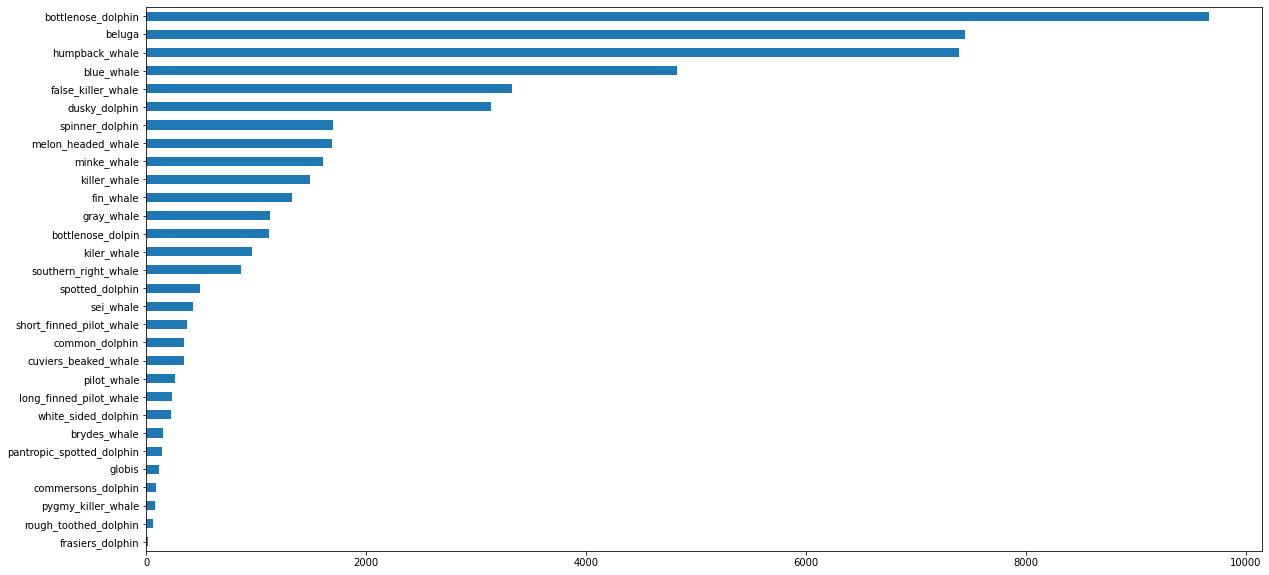

In [34]:
plt.figure(figsize=(20, 10))
df['species'].value_counts().sort_values(ascending=True).plot(kind='barh');

In [35]:
image_dir = Path('../input/happywhaleimagessortedbyspecies/train_species_list')

In [36]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

In [37]:
image_df

,Filepath,Label
0,../input/happywhaleimagessortedbyspecies/train...,short_finned_pilot_whale
1,../input/happywhaleimagessortedbyspecies/train...,short_finned_pilot_whale
2,../input/happywhaleimagessortedbyspecies/train...,short_finned_pilot_whale
3,../input/happywhaleimagessortedbyspecies/train...,short_finned_pilot_whale
4,../input/happywhaleimagessortedbyspecies/train...,short_finned_pilot_whale
...,...,...
51028,../input/happywhaleimagessortedbyspecies/train...,bottlenose_dolphin
51029,../input/happywhaleimagessortedbyspecies/train...,bottlenose_dolphin
51030,../input/happywhaleimagessortedbyspecies/train...,bottlenose_dolphin
51031,../input/happywhaleimagessortedbyspecies/train...,bottlenose_dolphin


In [38]:
image_df['Label'].value_counts()


bottlenose_dolphin           9664
beluga                       7443
humpback_whale               7392
blue_whale                   4830
false_killer_whale           3326
dusky_dolphin                3139
spinner_dolphin              1700
melon_headed_whale           1689
minke_whale                  1608
killer_whale                 1493
fin_whale                    1324
gray_whale                   1123
bottlenose_dolpin            1117
kiler_whale                   962
southern_right_whale          866
spotted_dolphin               490
sei_whale                     428
short_finned_pilot_whale      367
common_dolphin                347
cuviers_beaked_whale          341
pilot_whale                   262
long_finned_pilot_whale       238
white_sided_dolphin           229
brydes_whale                  154
pantropic_spotted_dolphin     145
globis                        116
commersons_dolphin             90
pygmy_killer_whale             76
rough_toothed_dolphin          60
frasiers_dolph

In [39]:
train_df, test_df = train_test_split(image_df, train_size=0.8, shuffle=True, random_state=1)


In [40]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [41]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 40826 validated image filenames belonging to 30 classes.
Found 10207 validated image filenames belonging to 30 classes.


In [42]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [43]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(30, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [44]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [45]:
r = model.fit(
    train_images,
    validation_data=test_images,
    epochs=5,
    )

Epoch 1/5
1276/1276 [==============================] - 155s 120ms/step - loss: 0.7081 - accuracy: 0.7903 - val_loss: 0.5015 - val_accuracy: 0.8443
Epoch 2/5
1276/1276 [==============================] - 150s 118ms/step - loss: 0.4338 - accuracy: 0.8634 - val_loss: 0.5241 - val_accuracy: 0.8386
Epoch 3/5
1276/1276 [==============================] - 148s 116ms/step - loss: 0.3507 - accuracy: 0.8870 - val_loss: 0.4261 - val_accuracy: 0.8665
Epoch 4/5
1276/1276 [==============================] - 147s 115ms/step - loss: 0.2905 - accuracy: 0.9040 - val_loss: 0.4281 - val_accuracy: 0.8700
Epoch 5/5
1276/1276 [==============================] - 151s 118ms/step - loss: 0.2480 - accuracy: 0.9164 - val_loss: 0.4433 - val_accuracy: 0.8715


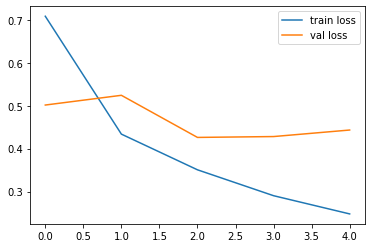

In [46]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

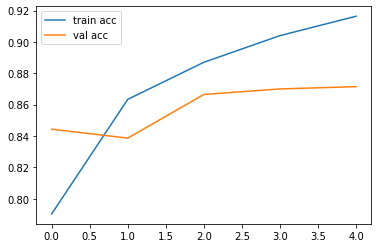

In [47]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


In [48]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 87.15%


In [49]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)


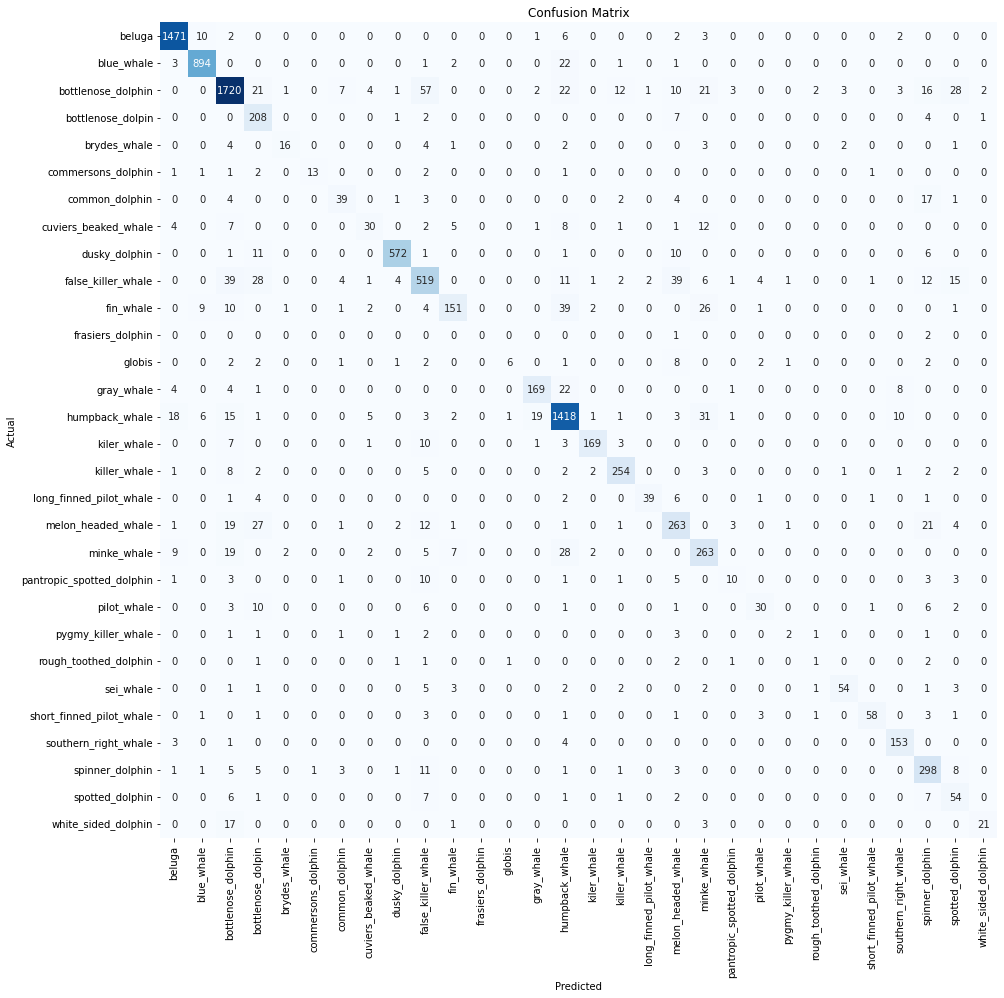

In [50]:
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(30) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(30) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [51]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                            precision    recall  f1-score   support

                   beluga       0.97      0.98      0.98      1497
               blue_whale       0.97      0.97      0.97       924
       bottlenose_dolphin       0.91      0.89      0.90      1936
        bottlenose_dolpin       0.64      0.93      0.76       223
             brydes_whale       0.80      0.48      0.60        33
       commersons_dolphin       0.93      0.59      0.72        22
           common_dolphin       0.67      0.55      0.60        71
     cuviers_beaked_whale       0.67      0.42      0.52        71
            dusky_dolphin       0.98      0.95      0.96       602
       false_killer_whale       0.77      0.75      0.76       690
                fin_whale       0.87      0.61      0.72       247
         frasiers_dolphin       0.00      0.00      0.00         3
                   globis       0.75      0.21      0.33        28
              

In [52]:
model.save('WCvF.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [53]:
from keras.models import load_model
from keras.preprocessing.image import load_img,img_to_array
model1 = load_model('./WCvF.h5',compile=False)

In [54]:
lab = train_images.class_indices
lab={k:v for v,k in lab.items()}

In [55]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model1.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = lab[y]
    return res

'southern_right_whale'

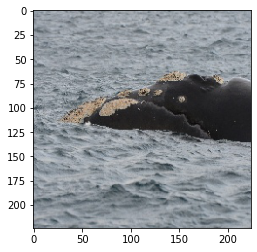

In [56]:
img='../input/happywhaleimagessortedbyspecies/train_species_list/southern_right_whale/01e1590083b363.jpg'
pic=load_img('../input/happywhaleimagessortedbyspecies/train_species_list/southern_right_whale/01e1590083b363.jpg',target_size=(224,224,3))
plt.imshow(pic)
output(img)